## 0. Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math


#create noise
def calculate_noise(slowness_mat):
    """
    :param slowness_mat: 11X13 slowness matrix
    :return: noise vector
    """
    #normal distributed with mean value 0
    n = np.random.normal(0,size=2*n_det)
    #and condition ||n||=||t_pure||/18
    t_pure_1d = calculate_t(slowness_mat,flat_mat=True)
    t_pure_norm = np.linalg.norm(t_pure_1d)
    n_norm = t_pure_norm/18
    #find scaling factor
    y = n_norm/np.linalg.norm(n)
    #create nosise
    n = n * y
    #test
    if verbose:
        print(f"""The noise vector fulfil condition? {round(np.linalg.norm(n),5)==round(n_norm,5)}""")
    return n

def calculate_t_obs(n,slowness_mat,flat_mat=True):
    """

    :param n: noise vector
    :param slowness_mat: 11X13 slowness matrix
    :param flat_mat: returns t_obs as a 1d vector
    :return: t_obs as a 2X12 vector(number of waves X number of detectors)
    """
    t_pure1d = calculate_t(slowness_mat,flat_mat=True)
    t_obs1d = t_pure1d + n
    t_obs = np.zeros((2,n_det))
    t_obs[0] = t_obs1d[:n_det]
    t_obs[1]= t_obs1d[n_det:n_det*2]
    if flat_mat:
        return t_obs1d
    return t_obs


# find the solution using tikhonov regularization
# build a tikhonov regularization function
def tikhonov_reg(G,d,eps):
    """

    :param G: 20X143 G matrix calculated with G_mat()
    :param d: data parameters d=Gm in this case 1d t_obs
    :param eps: float optimization parameter
    :return: calculated model
    """
    m = np.linalg.inv(G.T@G + np.identity(143)*eps**2)@G.T@d
    return m

def solve_eps(eps,G,d,error):
    """

    :param eps: float optimization parameter calculated with calculate_epsilon()
    :param G: 20X143 G matrix calculated with G_mat()
    :param d: data parameters d=Gm in this case 1d t_obs
    :param error: noise std
    :return: optimization value where epsilon minimize the error
    """
    m = tikhonov_reg(G,d,eps)
    s = np.abs(np.linalg.norm(d - G@m) - d.shape[0]*error**2)

    return s

#calculate epsilon
def calculate_epsilon(n,G,t_obs1d):
    """

    :param n: noise vector
    :param t_obs1d: t_obs
    :return:  list of scanned epsilons and solution, value of epsilon that minimise the function and index
    """
    #data
    error = n.std()
    resolution = 500
    epsilons = np.linspace(0.0001,0.1,resolution)
    solutions = np.zeros(resolution)
    for i, eps in enumerate(epsilons):
        solutions[i] = solve_eps(eps,G,t_obs1d,error)
    #find the epsilon that minimize the soultions
    min_index = np.argmin(solutions)
    min_eps = epsilons[min_index]
    return epsilons, solutions, min_eps, min_index


#calculate model with optimal epsilon
def model_calculation(G, t_obs1d,min_eps,min_index,slowness_mat,eps_plot=False):
    m = tikhonov_reg(G,t_obs1d,min_eps)
    #plot
    if eps_plot:
        plot_epsilon(epsilons,solutions,min_eps,min_index,'epsilon_vs_error')
    # create a 11X13 m matrix for visualization
    m_mat = m.reshape(z,x)*1e3
    #plot model obtained after tikhonov_reg with real model
    models_plots(m_mat, slowness_mat*1e3, 3, 3, cmap_list[8], cmap_list[0], 'Model Matrix [m/ms]', 'Slowness Matrix [ms/m]')
    #
    #calculate t
    t = G@m
    t_mat = t.reshape(2,12)
    # plot detector model calculated times
    detector_times_plot(t_mat, 5,'calculated',cmap_list[11])
    #test
    t_obs = calculate_t_obs(n,slowness_mat,flat_mat=False)
    test2 = np.round(t,4)==np.round(np.ravel(t_obs),4)


In [2]:
def models_plots(M1, M2, r1, r2, color1, color2, name1, name2):
    """

    :param M1: Matrix  1
    :param M2: Matrix 2
    :param r1: int, rounding number
    :param r2: int, rounding number
    :param color1: heatmap colors from cmap_list
    :param color2: heatmap colors from cmap_list
    :param name1: 1st figure title
    :param name2: 2nd figure title
    :return: plot of 2 model matrix
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    sns.heatmap(np.round(M1, r1), annot=True, linewidth=0.5, cmap=color1, cbar=False, ax=axs[0])
    sns.heatmap(np.round(M2, r2), annot=True, linewidth=0.5, cmap=color2, cbar=False, ax=axs[1])
    axs[0].set_xlabel('m')
    axs[0].set_ylabel('m')
    axs[1].set_xlabel('m')
    axs[1].set_ylabel('m')
    axs[0].set_title(f'{name1}')
    axs[1].set_title(f'{name2}')
    if save_fig:
        plt.savefig(f'model')
    plt.show()


def detector_times_plot(M, r,name,color):
    """

    :param M: Detector time detection matrix
    :param r: int, rounding value
    :param name: name in the title
    :return: heatmap of time recorded by detectors
    """
    fig, axs = plt.subplots(figsize = (12,4))
    axs= sns.heatmap(np.round(M,r),annot=True, linewidth=0.5,cmap=color, cbar=False)
    axs.set_yticklabels(['Wave 1','Wave 2'])
    axs.set_xlabel('Detector Position')
    axs.set_title(f'Time({name}) Anomaly in Seconds')
    if save_fig:
        plt.savefig(f'Time({name})')
    plt.show()

#plot epsilon minimization fit
def plot_epsilon(eps,s,min_eps,min_index, name):
    """

    :param eps: range of epsilons
    :param s: solve epsilon solutions
    :param min_eps: minimum epsilon
    :param min_index: minimum epsilon index
    :param name: name to save graph
    :return: Error vs epsilon plot
    """
    fig, ax = plt.subplots(figsize = (12,4))
    ax.plot(eps,s)
    ax.set_xlabel('$\\epsilon$')
    ax.set_ylabel('Error')
    ax.set_title('Epsilon Minimum Fit')
    ax.annotate(f"Min $\\epsilon$ = {min_eps:1.4f}",(eps[min_index],s[min_index]))
    if save_fig:
        plt.savefig(f'{name}')
    plt.show()

In [3]:
def model_simulation(x1,x2,z1,z2):
    #get matrices
    #slowness_mat, velocity_mat = model_anomaly(4,7,1,9)
    slowness_mat, velocity_mat = model_anomaly(x1, x2, z1, z2)
    #plot velocity matrix with slowness
    models_plots(velocity_mat, slowness_mat*1e3, 3, 3, cmap_list[10], cmap_list[0], 'Velocity Matrix [m/s]', 'Slowness Matrix [ms/m]')

    #m vector is the flattened slowness_mat
    m_test = np.ravel(slowness_mat)
    #test
    G = G_mat()
    d = G@m_test
    t_pure = calculate_t(slowness_mat)
    test1 = d==np.ravel(t_pure)
    if test1.all():
        print("G matrix is correct")

    #plot wave pure times
    detector_times_plot(t_pure, 3,'pure',cmap_list[11])
    # compute noise
    n = calculate_noise(slowness_mat)
    #compute t_obs
    t_obs1d = calculate_t_obs(n,slowness_mat)
    t_obs = calculate_t_obs(n,slowness_mat,flat_mat=False)
    #plot wave observed  times
    detector_times_plot(t_obs, 5,'observed',cmap_list[11])
    return slowness_mat,n,G,t_obs1d


def model_anomaly(x1, x2, z1, z2):
    """

    :param x1: int, anomaly coordinate x1
    :param x2: int, anomaly coordinate x2
    :param z1: int, anomaly coordinate z1
    :param z2: int, anomaly coordinate z2
    :return: original model velocity matrix and slowness matrix
    """
    velocity_mat = np.zeros((z, x))
    velocity_mat[:, :] = v1
    # add the anomaly
    velocity_mat[z1:z2, x1:x2] = v2
    # get the slowness matrix sum(1/v(ui) -1/v)
    slowness_mat = 1 / velocity_mat - (1 / v1)
    return slowness_mat, velocity_mat



#calculate G matrix
#Gmatrix is  a 24X143 matrix, 24 is from the 12 detectors, and 143 is from 13*11, i.e we have 24 11X24 matrices one for each wave
def G_mat():
    """

    :return: 24X143 G matrix
    """
  #matrix G is 24 columns, and z*x rows
    G = np.zeros([n_det*2,x*z])
    #first 11 rows travel from the left(np.fliplr, flips the columns), first diagoal= np.eye(11, 13, 11-0) from the position of detectors
    for i in range(n_det):
        G[i] = np.ravel(np.fliplr(np.eye(z, x, z-i+1)))
     #the last 11 are waves traveling from the right and first diagonal =  np.eye(11,13,2+0) from detector position
    for i in range(n_det,n_det*2):
        j = i - n_det
        G[i] = np.ravel(np.eye(z,x,1+j))
        #G * distance in each square =sqrt(2)
    return G * math.sqrt(2)


#calculate t_pure
#this function knows exactly what the slowness matrix is and outputs the actual time anomaly
def calculate_t(slowness_mat,flat_mat=False):
    """

    :param slowness_mat: 11X13 slowness matrix
    :param flat_mat: bool if True returns 1X24 1d t_pure
    :return: 2X12 t_pure matrix
    """
    # wave 1 (from the left)
    #flip order of the matrix and get the trace increasing from 1X1 (first detector) to 3X3... until 12X12(last detector)
    
    tr_wave1 = [np.trace(np.fliplr(slowness_mat[0:i, 0:i])) for i in range(1, 13)]
    
    
    #to obtain the arrival time tr_wave are multiplied by the distance sqtr(2)
    t1_pure = np.array(tr_wave1)*math.sqrt(2)
    #wave 2 (from the right)
    #calculate the traces with an ofset from colum 2(second detector) to column 12 last detector
    tr_wave2 = [np.sum(np.diagonal(slowness_mat,offset=i)) for i in range(1,13)]
    t2_pure = np.array(tr_wave2)*math.sqrt(2)
    #create t_pure, one matrix whit all measurment
    t_pure = np.zeros((2,len(t2_pure)))
    t_pure[0] = t1_pure
    t_pure[1] = t2_pure
    if verbose:
        print(f"""The time anomaly in seconds of the first wave detected by each detector are: \n{t1_pure}""")
        print(f"""The time anomaly in seconds of the second wave detected by each detector are: \n{t2_pure}""")

    if flat_mat:
        #flattening matrix
        t_pure_1d = np.ravel(t_pure)
        return t_pure_1d
    else:
        return t_pure


In [4]:
#%%
#General data
np.random.seed(27)
z = 11
x = 13
n_det = 12
v1 = 5          #5km/s

v2 = 5.2        #5.2km/s
save_fig = False
verbose = False
cmap_list = ["YlOrBr","Blues", "dark:salmon_r","#69d","seagreen","cubehelix","crest","flare","mako","rocket","Dark2_r","YlGnBu"]
#%%

# Introduction

Acoustic waves from distant sources can help reveal the structure of materials that they are travelling through. As the waves
propagate their speed is different depending on the structure. This speed change will show up as
small pertubations in the expected arrival times for an array of detectors. In our case we have
12 detectors on a straight line and 2 acoustic waves, one coming from each side. 


## 1. Arrival time anomalies

The arrival time anomalies for each wave can be seen down bellow

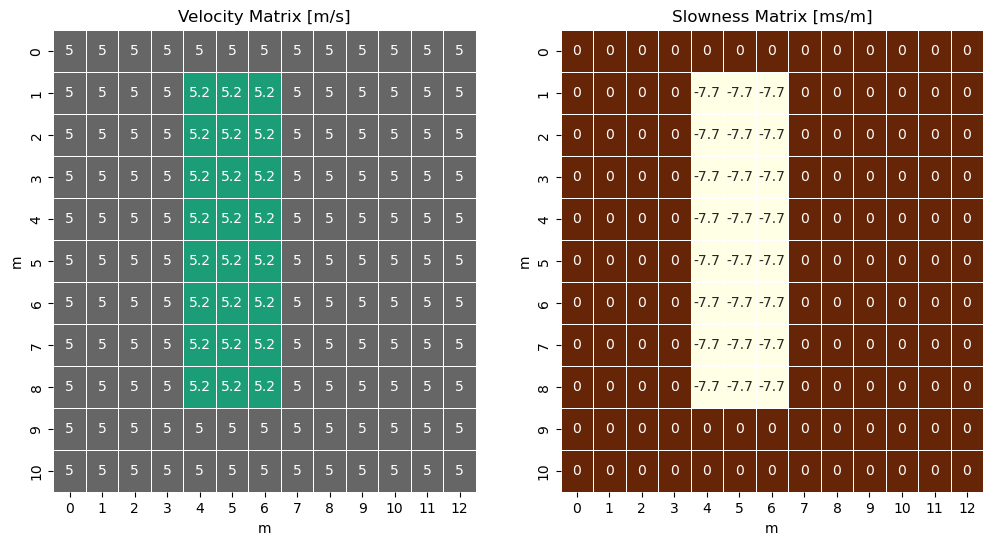

G matrix is correct


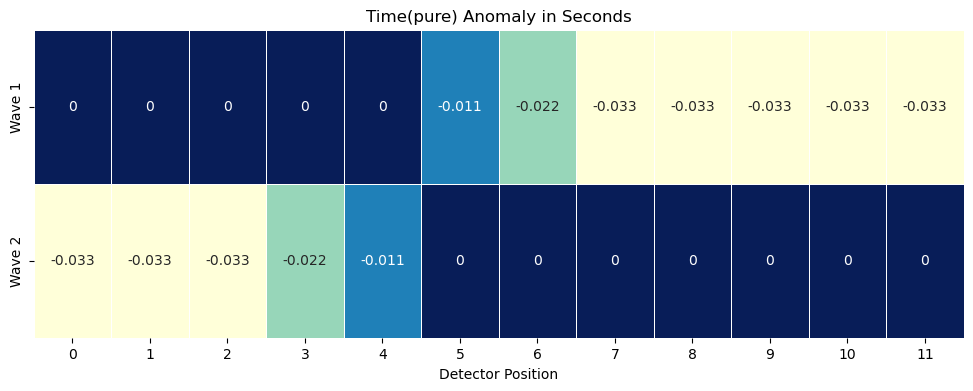

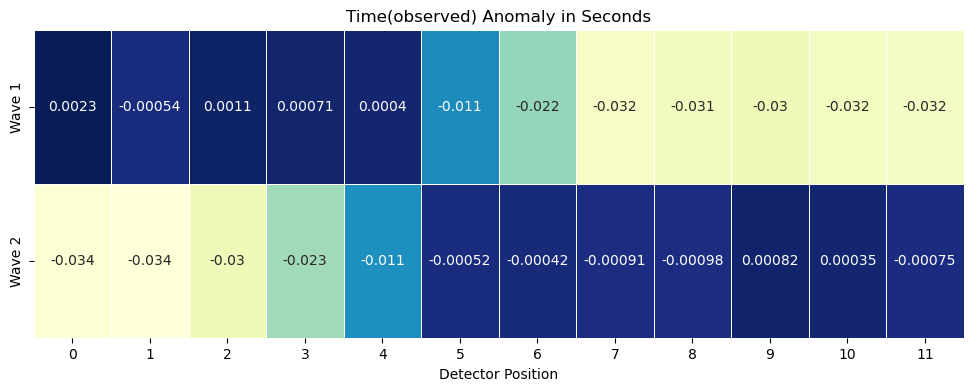

In [5]:
#%%test anomaly
# calculate problem with original anomaly x1=4,x2=7,z1=1,z2=9 to get slowness_mat, G matrix, noise and t_obs
slowness_mat, n,G, t_obs1d = model_simulation(4,7,1,9)


## 2. Discretize Equation

To discretize Equation (1) for the given problem, you can approximate the integral by subdividing the area into smaller squares. Let's denote the slowness anomaly in each square as \(s_{i,j}\), where \(i\) is the row index and \(j\) is the column index. Each square has dimensions of \(1 $\times$ 1\) meter. The arrival-time anomaly \($t_{\gamma}$\) for a wave propagating along a ray \($\gamma)$ can then be approximated as the sum of slowness anomalies along the path:

 $ t_{\gamma} = \Sigma_{i}^{\gamma}s_{\gamma}(u_i)$  
 with $s_{\gamma}(u_i)$ is the time anomaly due to the the ray $\gamma$ at the specific location on the grid denoted by i. 

Given that I want to calculate the time anomaly, I only care about the squares that have a different propagation speed and how much they differ from the regular propagation speed
 $s_{\gamma}(u_i) = d_{grid}\left(\frac{1}{v_{white}} - \frac{1}{v_{grey}}\right) = \sqrt(2)\left(\frac{1}{5.0} - \frac{1}{5.2}\right) = 0.01088 sec\equiv t_0$ (constant)



## 3. The inverse problem

In this step, we introduce noise to simulate the observed data vector $\vec{t_{\text{obs}}}$:

$
\vec{t_{\text{obs}}} \quad \text{(Observed Data):}
$
Represents the time anomalies observed at 12 detectors.
Modeled as $\vec{t_{\text{obs}}} \approx \vec{t_{\text{pure}}} + \vec{n}$.
Here, $\vec{n}$ accounts for the noise in our observations.

Now, let's delve into the mapping aspect using the matrix $\mathbf{G}$, where $\mathbf{G}\vec{s} = \vec{t_{\text{obs}}}$:

$
\mathbf{G} \quad \text{(Mapping Matrix):}
$
Describes how the unknown vector $\vec{s}$ (representing time anomalies in the $13 \times 11$ area) contributes to the observed data vector $\vec{t_{\text{obs}}}$.

Our objective is to find $\vec{s}$ by solving the system of equations $\mathbf{G}^T \mathbf{G}\vec{s} \approx \mathbf{G}^T(\vec{t_{\text{pure}}} + \vec{n})$.



## 4. Linearity

A problem is considered linear when it satisfies the principles of superposition and homogeneity. Superposition implies that the response to a sum of inputs is equal to the sum of the responses to individual inputs. Homogeneity implies that scaling the input scales the output proportionally. Both are straight forward to be shown by using equation 1

$t_{\gamma} = \int_{\gamma} \kappa s(u) \,du = \kappa \int_{\gamma} s(u) \,du \quad $ $\;\;\;\;\;\;$  which proves homogeneity

$t_{\gamma} = \int_{\gamma} s(u) + t(u) \,du = \int_{\gamma} s(u) \,du + \int_{\gamma} t(u) \,du$  $\;\;\;\;\;\;$ which proves additivity

## 5. Uniqueness
The solution is not unique. The non-uniqueness of the solution is influenced by both the lack of data in specific regions and the redundancy of information in segments affected by only one wave.


 ### Incomplete Wave Coverage:
 The uniqueness of the solution is compromised due to certain regions within the object where waves do not       propagate. These areas provide no information about the internal structure, creating uncertainties regarding the consistency or composition of those regions.
It underscores the importance of achieving comprehensive wave coverage across the entire object to enhance the reliability of the analysis.
### Redundant Information in Segments:

Another factor contributing to the non-uniqueness of the solution is the presence of segments consisting of multiple blocks that are only affected by a single wave. In such cases, the arrangement or permutation of the individual blocks within those segments does not impact the resulting analysis.
This implies that certain configurations of the blocks lead to equivalent outcomes, introducing variability in the solutions and emphasizing the need for additional constraints or information to pinpoint a unique solution.


## 6. Solution using Tikhonov Regularization

We find a solution using Tikhonov Regularization:

$\mathbf{m_{\text{est}}} = (\mathbf{G}^T \mathbf{G} - \epsilon^2 \mathbf{I})^{-1} \mathbf{G}^T \mathbf{d}$

To ensure that the solution barely fits the data, we minimize the following expression for $\epsilon$:

$\| \mathbf{d} - \mathbf{G} \mathbf{m_{\text{est}}} \| - \| n\sigma \| \quad (1)$

Here, $n\sigma = 0.001$ represents the errors on the data, and it is the same for all data points. We then scan over $\epsilon$ to find a minimum for equation (1). This process is illustrated in figure bellow. The solution $\mathbf{m_{\text{est}}}$ with the optimal $\epsilon = 0.0768$ can be seen down bellow.

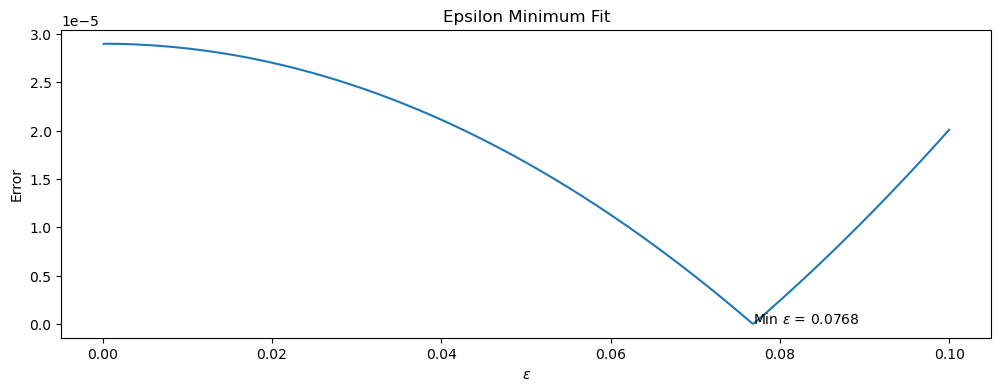

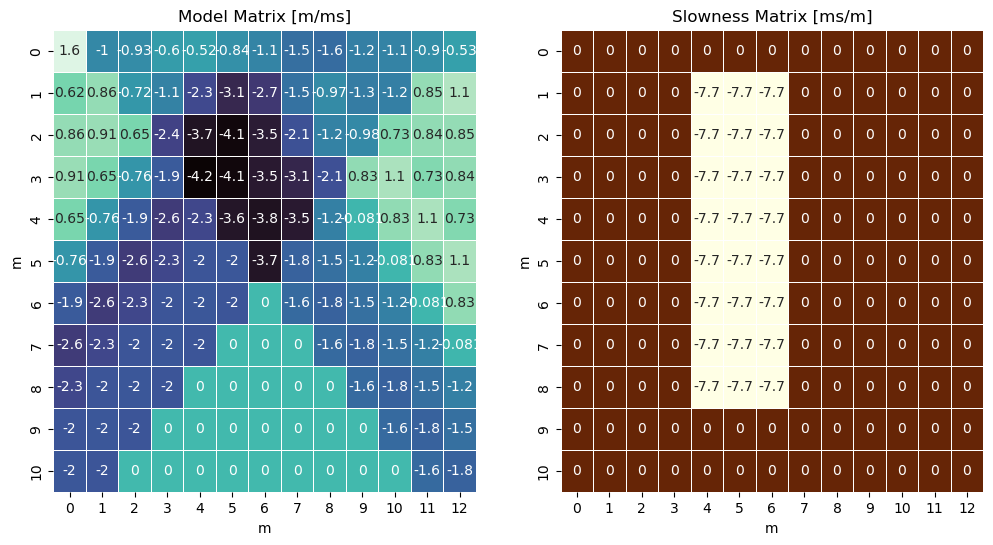

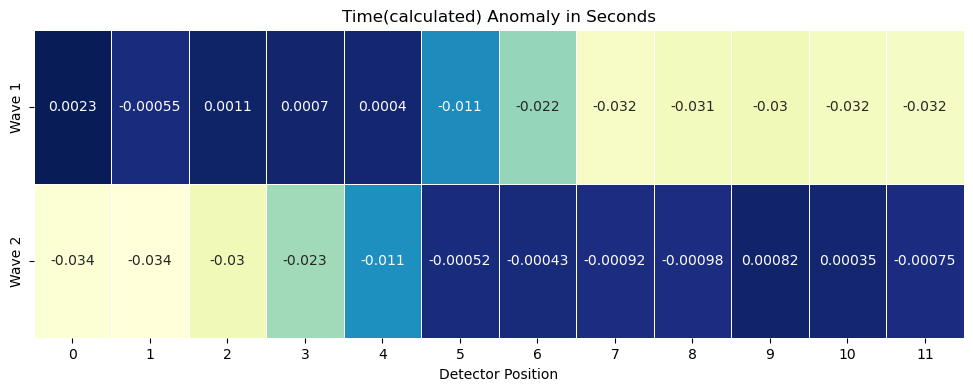

In [6]:
#calculate optimal epsilon
epsilons,solutions, min_eps, min_index = calculate_epsilon(n,G,t_obs1d)
model_calculation(G, t_obs1d,min_eps,min_index,slowness_mat,eps_plot=True)

# 7. Delta anomaly

In order to calculate the resolution, we replace the initial slowness matrix anomaly with single-pixel point,
and see how well we can predict m. Depending on the position of the delta function we get completely different results. In total there are 3 cases (all executed bellow):
* The anomaly is seen by 2 waves
* The anomaly is seen by only 1 wave
* No wave sees the anomaly. This makes it completely invisible thus, we expect to see a uniform result

In the first scenario, the model allows for the identification of the position of the delta anomaly. However, the result appears diffused due to the inherent limitations in the available data. Despite this diffusion, the approximate location of the anomaly is defined.

Conversely, in the second case, as anticipated, it is impossible to pinpoint the distance from the detector. Consequently, all blocks in the line of the wave uniformly share the anomaly. The small deviations observed in this case stem from the attempt to counterbalance the negatives present in empty squares, contributing to a nuanced yet undetermined distribution.

In the final scenario, as expected, no clear features are visible. This is because no waves directly interact with the anomaly. The lack of data in this case prevents any meaningful inference regarding the anomaly's characteristics.


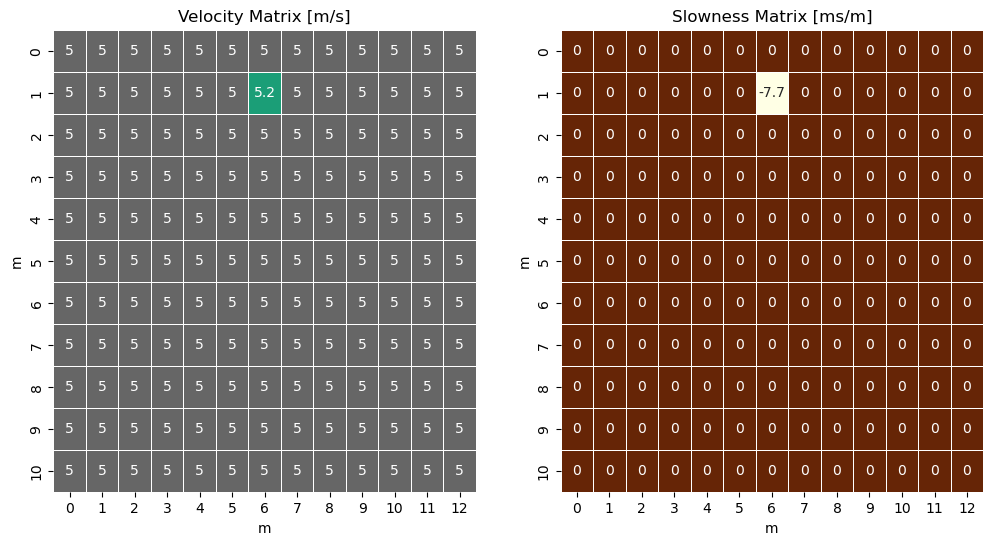

G matrix is correct


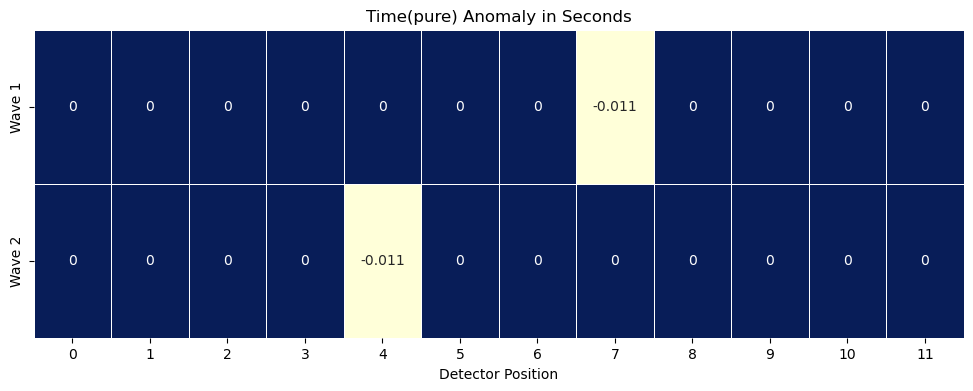

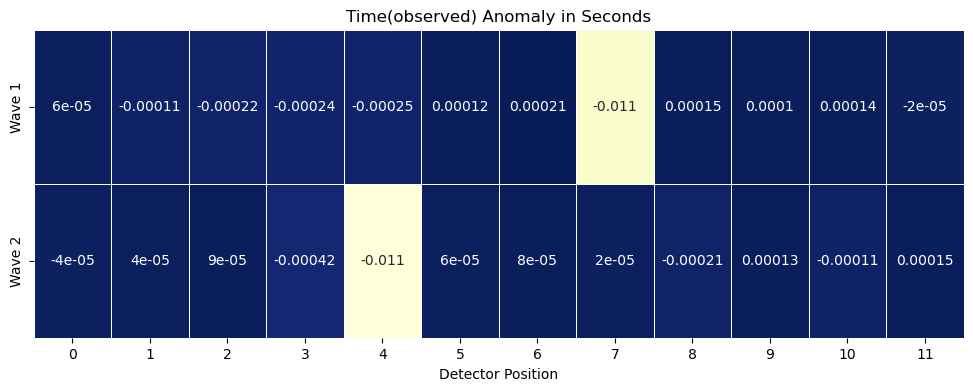

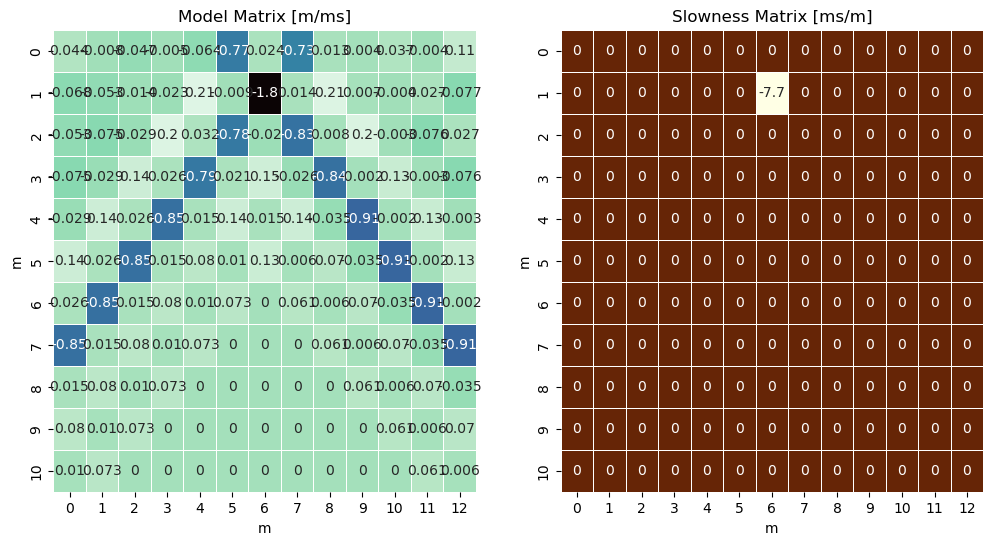

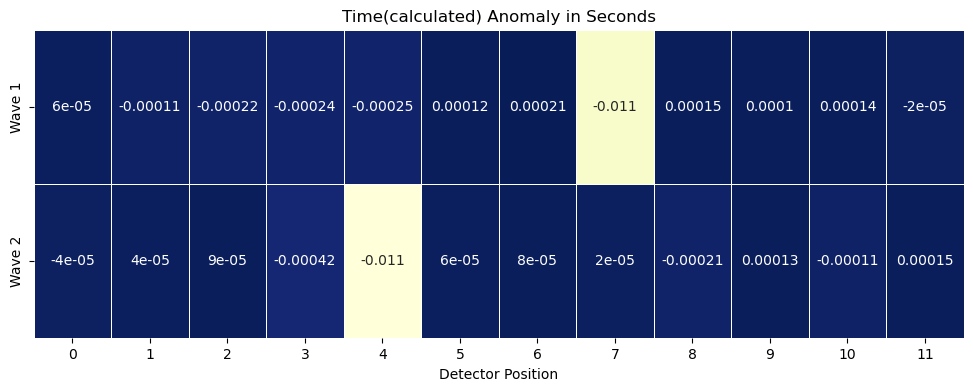

In [10]:
# calculate problem with 1X1 anomaly x1=6,x2=7,z1=1,z2=2 to get slowness_mat, G matrix, noise and t_obs
slowness_anomaly1, n_anomaly1,G_anomaly1, t_obs1d_anomaly1 = model_simulation(6,7,1,2)
model_calculation(G_anomaly1, t_obs1d_anomaly1,min_eps,min_index,slowness_anomaly1)

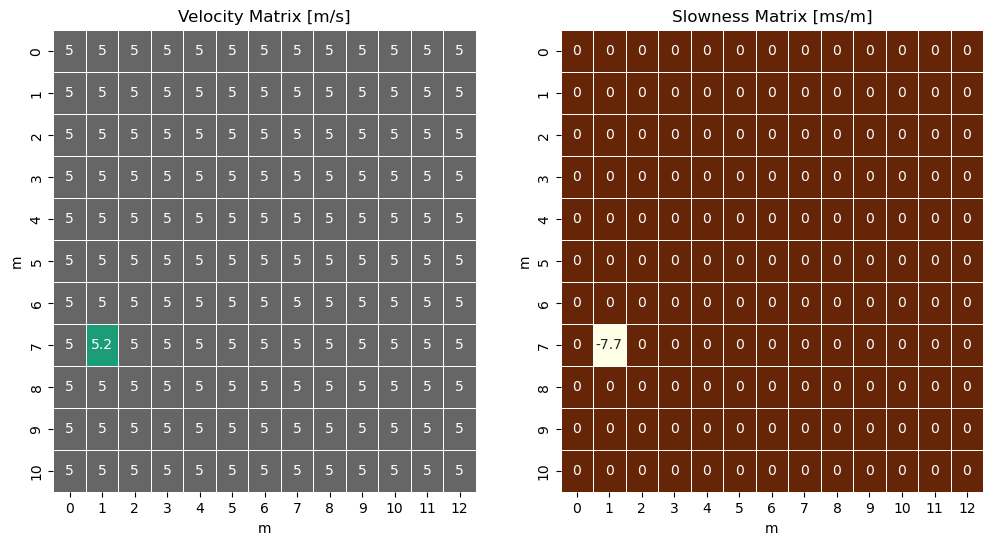

G matrix is correct


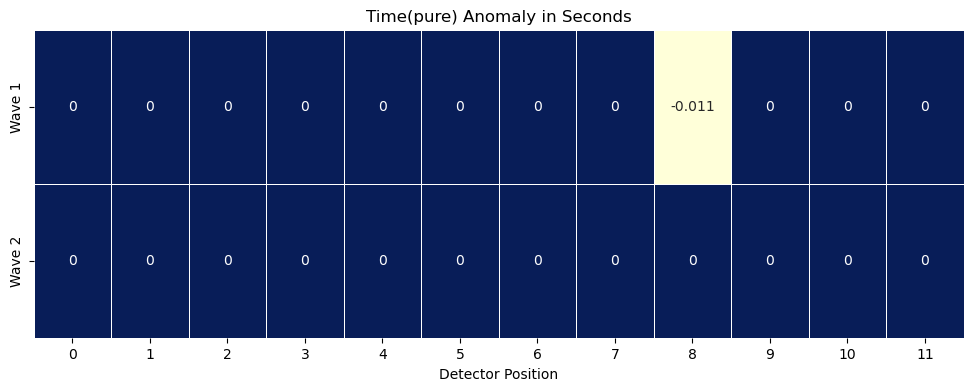

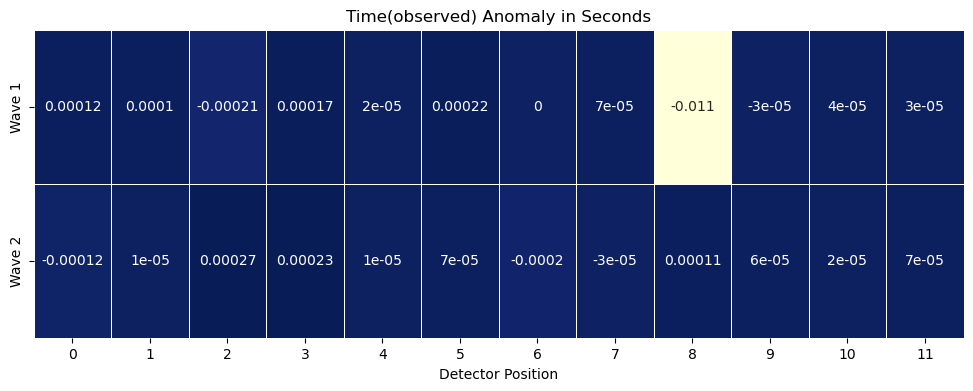

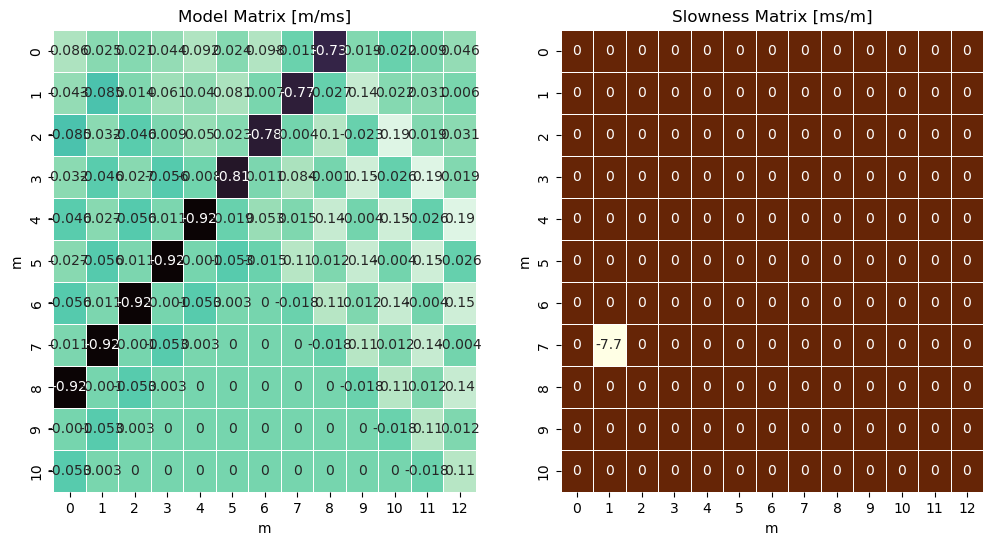

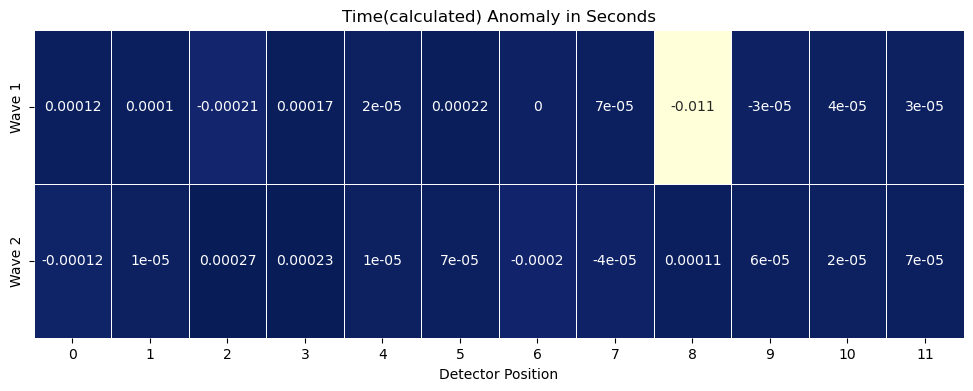

In [11]:
# calculate problem with 1X1 anomaly x1=1,x2=2,z1=7,z2=8 to get slowness_mat, G matrix, noise and t_obs
slowness_anomaly2, n_anomaly,G_anomaly2, t_obs1d_anomaly2 = model_simulation(1,2,7,8)
model_calculation(G_anomaly2, t_obs1d_anomaly2,min_eps,min_index,slowness_anomaly2)

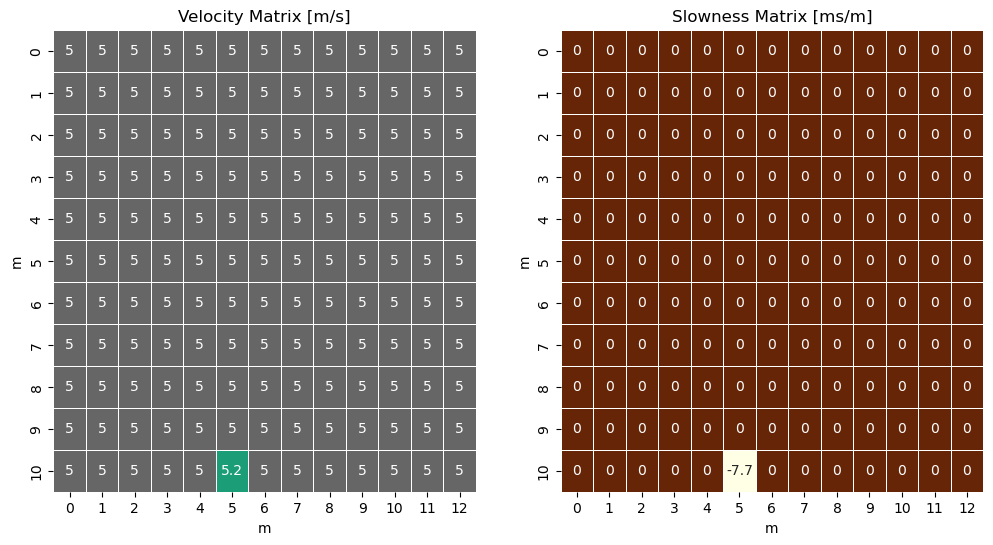

G matrix is correct


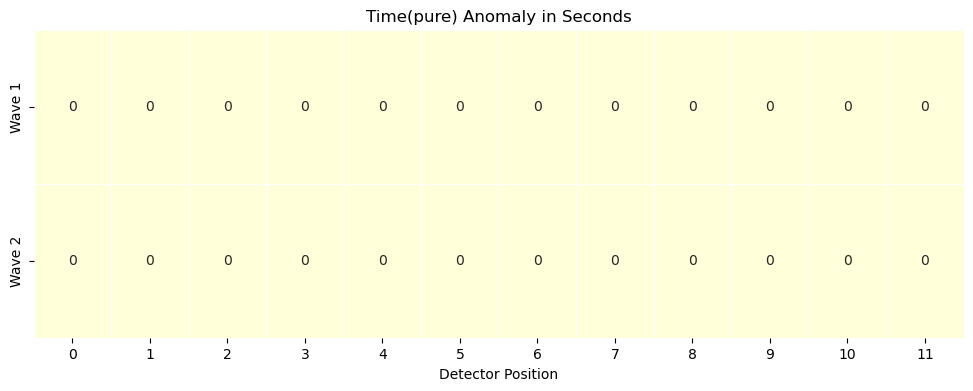

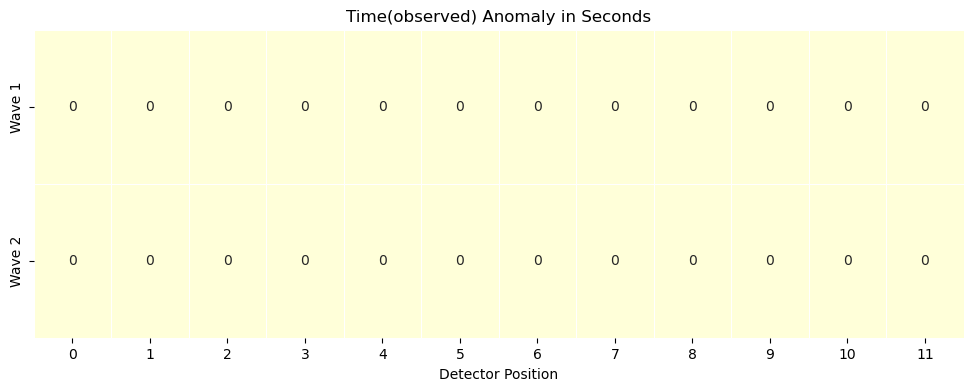

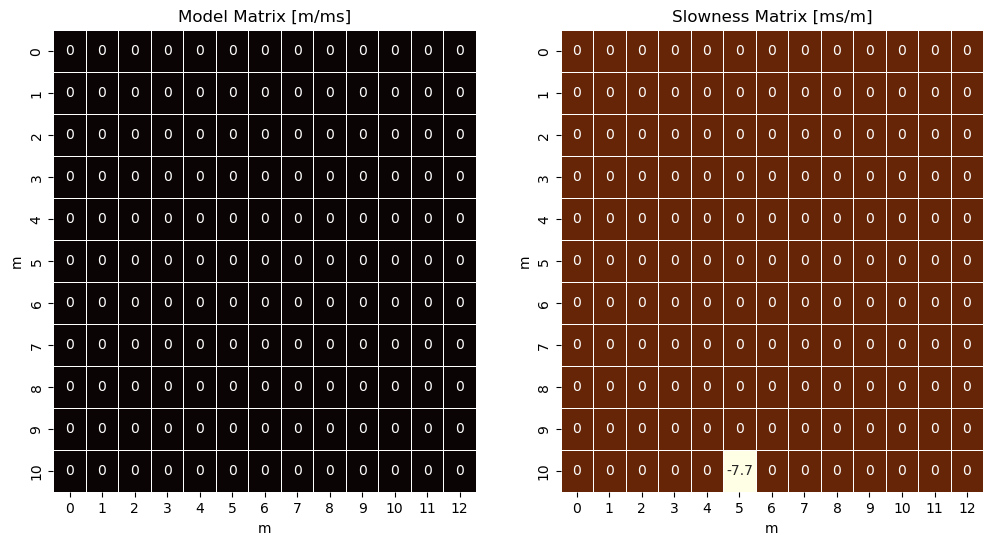

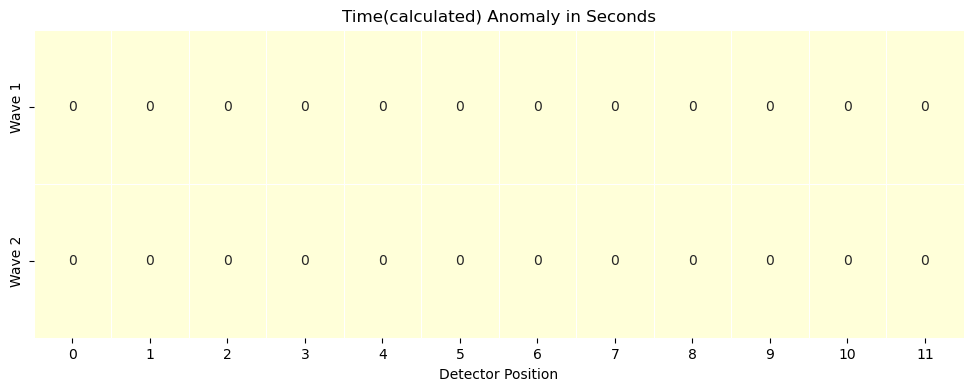

In [12]:
# calculate problem with 1X1 anomaly x1=5,x2=8,z1=10,z2=11 to get slowness_mat, G matrix, noise and t_obs
slowness_anomaly3, n_anomaly3,G_anomaly3, t_obs1d_anomaly3 = model_simulation(5,6,10,11)
model_calculation(G_anomaly3, t_obs1d_anomaly3,min_eps,min_index,slowness_anomaly3)

# Discussion 
Our method successfully identifies the anomaly, but its representation appears diffused due to limited data resolution. The top section of the initial anomaly, intersected by acoustic waves from both sides, is relatively well-defined. However, in the middle-left region, where only acoustic waves from the left side contribute, the representation becomes highly smeared. Additionally, the bottom part of the structure, which remains untraversed by any acoustic waves, is understandably not accurately reconstructed.

For a comparative illustration referring to the figure above, where a sharply defined anomaly is traversed by acoustic waves from both sides also experiences diffusion. Thus, the time anomaly is spread out along the length of the rays. Consequently, the other acoustic waves exhibit small positive components to counterbalance the smeared negatives.

Moreover, examining the case where the anomaly can be seen only from 1 wave reveals that our method encounters challenges in localizing the anomaly when it is solely traversed by acoustic waves from one side. This suggests that increasing the number of model parameters that have two rays running through it could enhance resolution. The  increase in resolution aligns with the concept of obtaining a more precise solution by introducing additional constraints through an over-determined system.